# Predication of bike rental count for Bikeshare system, Washinton D.C.

Predication of bike rental count hourly or daily based on the environmental and seasonal settings.


# Dataset

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pydotplus
from IPython.display import Image
%matplotlib inline

In [2]:
df = pd.read_csv("./Bike-Sharing-Dataset/hour.csv" )

## Variables
### Continuous
* temp : Normalized temperature in Celsius. The values are divided to 41 (max)
* atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

### Time
* dteday : date
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* weekday : day of the week (0: Sunday ~ 6: Saturday)

### Categorical
* season : season (1:winter, 2:spring, 3:summer, 4:fall)
* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
    - 0: non-holiday
    - 1: holiday
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
    - 0: weekend or holiday
    - 1: working day
* weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


### Missing Values

There are any missing values. Add part of day values using hour variable, and cleaning other categorical variables for the best thing.

In [4]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
cnt,0,0.0
weekday,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
workingday,0,0.0
registered,0,0.0


In [5]:
df['season'] = df['season'].replace({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})

In [6]:
def partOfDay(hour) :
    if hour >= 0 and hour < 6:
        return 'night'
    elif hour >= 6 and hour < 12 :
        return 'morning'
    elif hour >= 12 and hour < 18 :
        return 'afternoon'
    elif hour >= 18 and hour < 24 :
        return 'evening'

In [7]:
df['part_day'] = df['hr'].apply(lambda x : partOfDay(x))
df['workingday'] = df['workingday'].replace({0: 'HOLIDAY' , 1: 'WORK'})
df['weathersit'] = df['weathersit'].replace({1:'CLEAR', 2:'MIST', 3:'LIGHT', 4:'HEAVY'})
df['weekday'] = df['weekday'].replace({0:'Sun', 1: 'Mon', 2:'Tue', 3:'Wed', 4: 'Thr', 5:'Fri', 6:'Sat'})

### Exploring Target Variable

In [8]:
df['casual'].describe()

count    17379.000000
mean        35.676218
std         49.305030
min          0.000000
25%          4.000000
50%         17.000000
75%         48.000000
max        367.000000
Name: casual, dtype: float64

### Distribution of Bike Rent Count

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


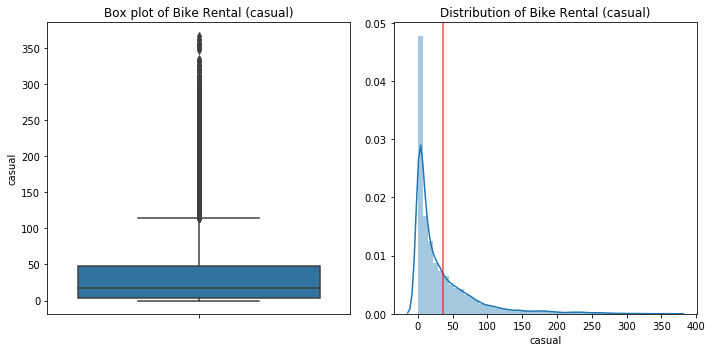

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(df['casual'], orient = 'v')
plt.title("Box plot of Bike Rental (casual)")
plt.subplot(1,2,2)
sns.distplot(df['casual'])
plt.axvline(x = df['casual'].mean(), color = 'r', alpha = .7)
plt.title("Distribution of Bike Rental (casual)")
plt.tight_layout()
plt.show()

### Handling Non-normality (Box-Cox Transformation and Log Transformation)

In [10]:
## Try transform as boxcox method and log for the dealing with non-normality
casual_boxcox,_ = boxcox(df["casual"]+1)
casual_log = np.log(df['casual']+1)
## **Note that Box-Cox, log, and square root transformations only work when all datapoints are positive**.

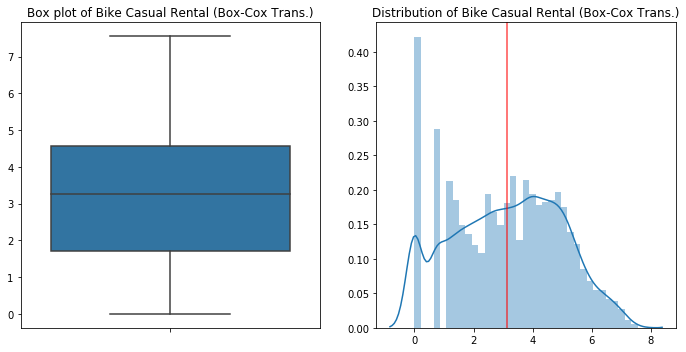

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(casual_boxcox, orient = 'v')
plt.title("Box plot of Bike Casual Rental (Box-Cox Trans.)")
plt.subplot(1,2,2)
sns.distplot(casual_boxcox)
plt.axvline(x = casual_boxcox.mean(), color = 'r', alpha = .7)
plt.title("Distribution of Bike Casual Rental (Box-Cox Trans.)")
plt.tight_layout()
plt.show()

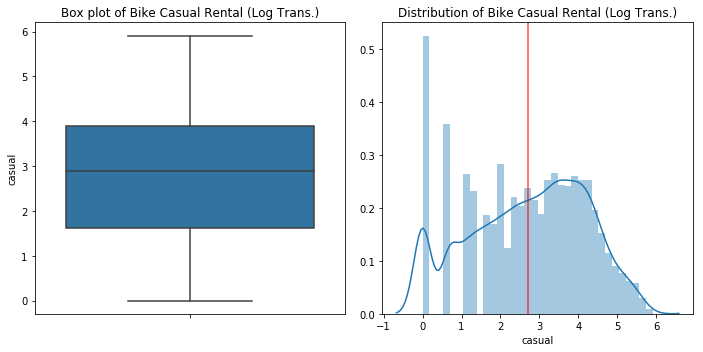

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(casual_log, orient = 'v')
plt.title("Box plot of Bike Casual Rental (Log Trans.)")
plt.subplot(1,2,2)
sns.distplot(casual_log)
plt.axvline(x = casual_log.mean(), color = 'r', alpha = .7)
plt.title("Distribution of Bike Casual Rental (Log Trans.)")
plt.tight_layout()
plt.show()

In [13]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

print('Box-Cox Transformation -----------------------------------------------------------------')
jb_stats = jarque_bera(casual_boxcox)
norm_stats = normaltest(casual_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print('Log Transformation ---------------------------------------------------------------------')
jb_stats = jarque_bera(casual_log)
norm_stats = normaltest(casual_log)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))



Box-Cox Transformation -----------------------------------------------------------------
Jarque-Bera test statistics is 571.5639002006109 and p value is 0.0
Normality test statistics is 2225.149951182718 and p value is 0.0
Log Transformation ---------------------------------------------------------------------
Jarque-Bera test statistics is 712.227689424493 and p value is 0.0
Normality test statistics is 2297.117251412491 and p value is 0.0


**Note**
The p-values are 0 which indicates that the distribution of the log transformed variables is statistically different from the normal distribution. However, these transformations might still be useful. In general, working with distributions that "look" normal (with 2 tails on the left and right and a clustering of values around the mean) is easier than working with 1 tailed distributions.

For the reason above, we choose Box-Cox Transformed target value for the modeling.

In [14]:
df['casual_boxcox'] = casual_boxcox

## Exploring Continuous Variables

In [15]:
continuousList = ['temp', 'atemp', 'hum', 'windspeed','casual_boxcox']

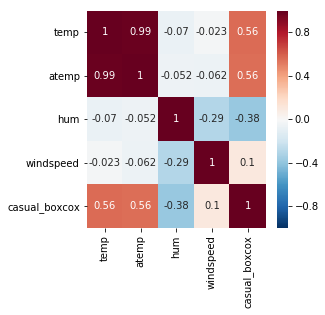

In [16]:
plt.figure(figsize=(4,4))
sns.heatmap(df[continuousList].corr(), cmap="RdBu_r", annot=True, vmin = -1, vmax = 1)
plt.show()

In [17]:
np.abs(df[continuousList].corr()).sort_values(by = 'casual_boxcox', ascending = False)['casual_boxcox']

casual_boxcox    1.000000
temp             0.563159
atemp            0.560140
hum              0.381973
windspeed        0.103856
Name: casual_boxcox, dtype: float64

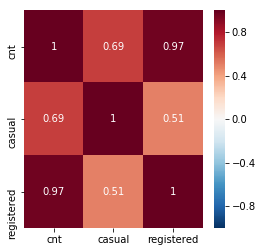

In [18]:
plt.figure(figsize=(4,4))
sns.heatmap(df[['cnt','casual','registered']].corr(), cmap="RdBu_r", annot=True, vmin = -1, vmax = 1)
plt.show()

Registered bike rental and total bike rental are highly correlated (0.97), so we can easily predict total count using registered customers. However, casual bike rental is relatively less related to the total rental. This factor should need to be predicted by building a prediction model.

__Temperature, Feeling Temperature, and Humidity__ are correlated with casual rental (> 0.30).
Temperature and Feeling Temperature are highly correlated (0.99), so we __exclude Feeling Temperature__ in the model.

## Exploring Categorical Variables

### Variation by Season

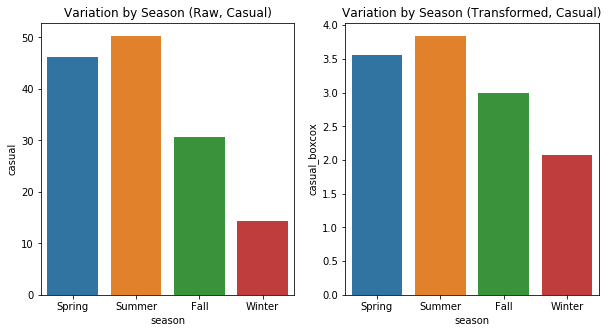

In [19]:
df_season= df.groupby('season').mean()['casual'].reset_index()
df_season_boxcox = df.groupby('season').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_season['season'], y = df_season['casual'], order = ['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Variation by Season (Raw, Casual)')
plt.subplot(1,2,2)
sns.barplot(x = df_season_boxcox['season'], y = df_season_boxcox['casual_boxcox'], order = ['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Variation by Season (Transformed, Casual)')

plt.show()

### Variation by Month

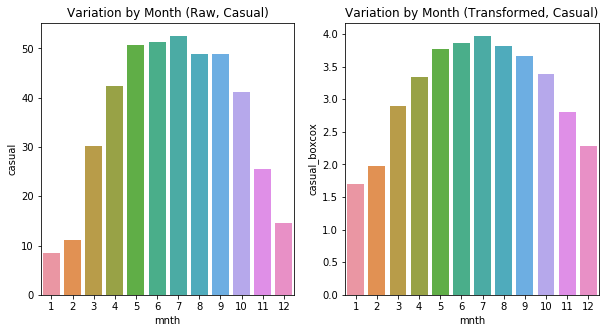

In [20]:
df_month = df.groupby('mnth').mean()['casual'].reset_index()
df_month_boxcox = df.groupby('mnth').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_month['mnth'], y = df_month['casual'])
plt.title('Variation by Month (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_month_boxcox['mnth'], y = df_month_boxcox['casual_boxcox'])
plt.title('Variation by Month (Transformed, Casual)')

plt.show()

### Variation by Weekday

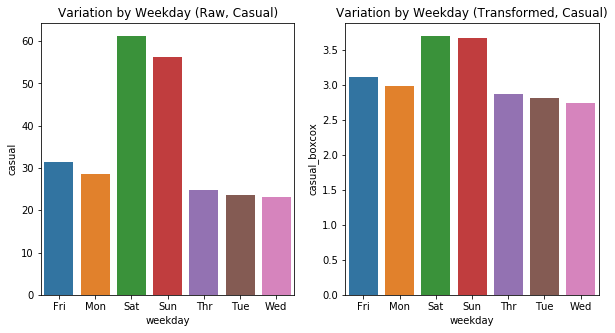

In [21]:
df_weekday = df.groupby('weekday').mean()['casual'].reset_index()

df_weekday_boxcox = df.groupby('weekday').mean()['casual_boxcox'].reset_index()


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_weekday['weekday'], y = df_weekday['casual'])
plt.title('Variation by Weekday (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_weekday_boxcox['weekday'], y = df_weekday_boxcox['casual_boxcox'])
plt.title('Variation by Weekday (Transformed, Casual)')

plt.show()

### Variation by Weather Situation

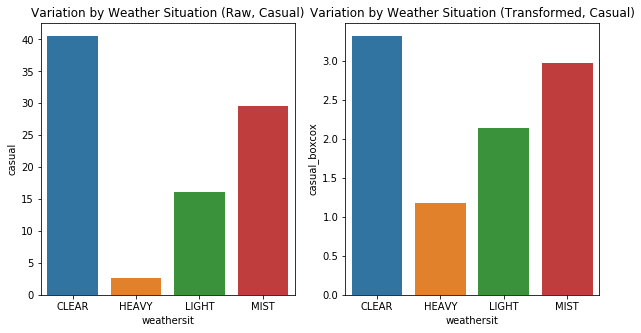

In [22]:
df_weather = df.groupby('weathersit').mean()['casual'].reset_index()
df_weather_boxcox = df.groupby('weathersit').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_weather['weathersit'], y = df_weather['casual'])
plt.title('Variation by Weather Situation (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_weather_boxcox['weathersit'], y = df_weather_boxcox['casual_boxcox'])
plt.title('Variation by Weather Situation (Transformed, Casual)')

plt.show()

### Variation by Whether Holiday or not

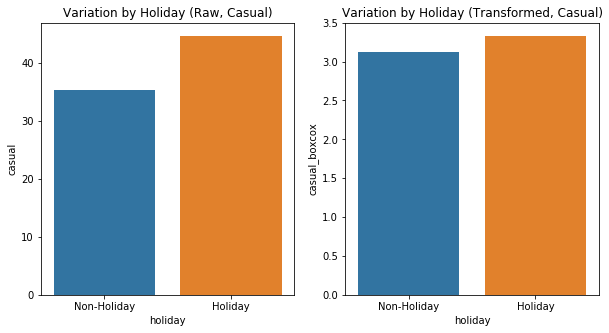

In [23]:
df_holiday = df.groupby('holiday').mean()['casual'].reset_index()
df_holiday['holiday'] = df_holiday['holiday'].replace({0: 'Non-Holiday', 1: 'Holiday'})
df_holiday_boxcox = df.groupby('holiday').mean()['casual_boxcox'].reset_index()
df_holiday_boxcox['holiday'] = df_holiday_boxcox['holiday'].replace({0: 'Non-Holiday', 1: 'Holiday'})

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_holiday['holiday'], y = df_holiday['casual'])
plt.title('Variation by Holiday (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_holiday_boxcox['holiday'], y = df_holiday_boxcox['casual_boxcox'])
plt.title('Variation by Holiday (Transformed, Casual)')

plt.show()

### Variation by Whether Working day or not

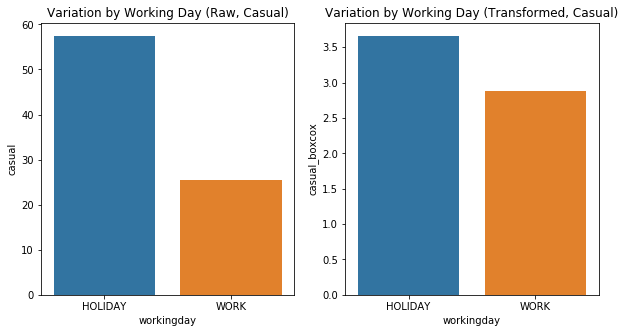

In [24]:
df_work = df.groupby('workingday').mean()['casual'].reset_index()
df_work_boxcox = df.groupby('workingday').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_work['workingday'], y = df_work['casual'])
plt.title('Variation by Working Day (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_work_boxcox['workingday'], y = df_work_boxcox['casual_boxcox'])
plt.title('Variation by Working Day (Transformed, Casual)')

plt.show()

### Variation by Hour

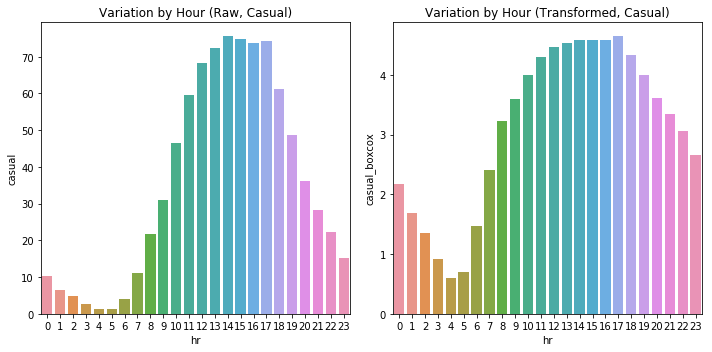

In [25]:
df_hour = df.groupby('hr').mean()['casual'].reset_index()
df_hour_boxcox = df.groupby('hr').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_hour['hr'], y = df_hour['casual'])
plt.title('Variation by Hour (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_hour_boxcox['hr'], y = df_hour_boxcox['casual_boxcox'])
plt.title('Variation by Hour (Transformed, Casual)')

plt.tight_layout()
plt.show()

### Variation by Parts of Day

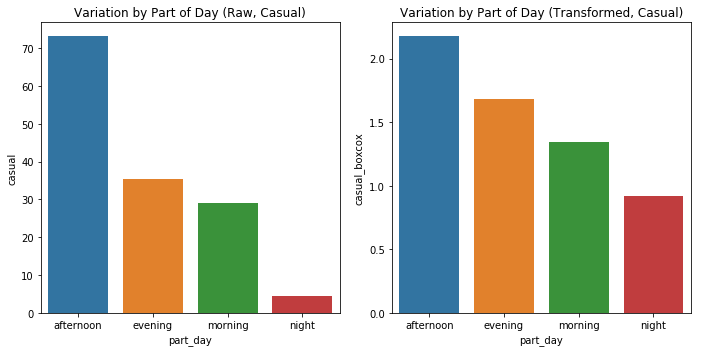

In [26]:
df_part = df.groupby('part_day').mean()['casual'].reset_index()
df_part_boxcox = df.groupby('part_day').mean()['casual_boxcox'].reset_index()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x = df_part['part_day'], y = df_part['casual'])
plt.title('Variation by Part of Day (Raw, Casual)')

plt.subplot(1,2,2)
sns.barplot(x = df_part_boxcox['part_day'], y = df_hour_boxcox['casual_boxcox'])
plt.title('Variation by Part of Day (Transformed, Casual)')

plt.tight_layout()
plt.show()

Season, Month, Weekday, Weather Situation, Holiday, Working day, hour and Parts of Day can be selected as categorical variables in my model, however, Month variable can be explained by using Season effect, Hour variable can be explained by Parts of Day, and Holiday and Working day have a very similar concept. Also the Weekday variable is explained by Working Day.

So we choose __Season, Weather Situation, Working day, and Parts of Day__ as features in our model.

## Chosen Features

In [27]:
continuous = ['temp', 'hum', 'windspeed']
categorical = ['season', 'weathersit','workingday', 'part_day']
X = df[continuous+categorical]

## Training and Testing Data
Let's split the data into training and testing sets.

In [28]:
y = df['casual_boxcox']
X = pd.get_dummies(df[continuous+categorical])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Regression Analysis

In [30]:
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          casual_boxcox   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2834.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:24:15   Log-Likelihood:                -19178.
No. Observations:               13903   AIC:                         3.838e+04
Df Residuals:                   13889   BIC:                         3.849e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
temp                   4.5169      0

This model's F statistic is 2834, and the associated p-value is very close to zero. This means that our features add some information to the reduced model and our model is useful in explaining charges. However, the r-squared (0.726) value has the rooms for improvement.

__weathersit_HEAVY and weathersit_LIGHT__ are not significant (P > 0.1), and we can say that there appears to be no relationship between casual bike rental and these variable.


In [31]:
X_droped = X.drop(['weathersit_HEAVY', 'weathersit_LIGHT'], axis = 1)
X_droped_train, X_droped_test, y_train, y_test = train_test_split(X_droped, y, test_size=0.2, random_state=101)
X_droped_train = sm.add_constant(X_droped_train)
results = sm.OLS(y_train, X_droped_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          casual_boxcox   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     3070.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:24:15   Log-Likelihood:                -19179.
No. Observations:               13903   AIC:                         3.838e+04
Df Residuals:                   13890   BIC:                         3.848e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7583      0

In [32]:
X_droped = X_droped.drop(['season_Summer'], axis = 1)
X_droped_train, X_droped_test, y_train, y_test = train_test_split(X_droped, y, test_size=0.2, random_state=101)
X_droped_train = sm.add_constant(X_droped_train)
results = sm.OLS(y_train, X_droped_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          casual_boxcox   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     3070.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:24:15   Log-Likelihood:                -19179.
No. Observations:               13903   AIC:                         3.838e+04
Df Residuals:                   13890   BIC:                         3.848e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7298      0

In [33]:
X_droped = X_droped.drop(['season_Winter'], axis = 1)
X_droped_train, X_droped_test, y_train, y_test = train_test_split(X_droped, y, test_size=0.2, random_state=101)
X_droped_train = sm.add_constant(X_droped_train)
results = sm.OLS(y_train, X_droped_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          casual_boxcox   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     3349.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:24:16   Log-Likelihood:                -19179.
No. Observations:               13903   AIC:                         3.838e+04
Df Residuals:                   13891   BIC:                         3.847e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7162      0

In [34]:
lrm = LinearRegression()
lrm.fit(X_droped_train.drop(['const'], axis=1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
X_droped_train.drop(['const'], axis=1)
y_preds_train = lrm.predict(X_droped_train.drop(['const'], axis=1))
y_preds_test = lrm.predict(X_droped_test)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


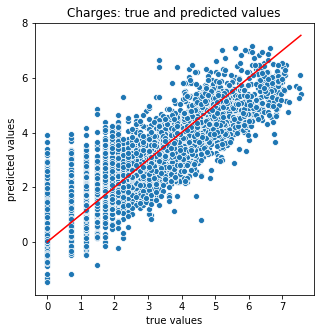

R-squared of the model in the training set is: 0.7261810614058843
-----Test set statistics-----
R-squared of the model in the test set is: 0.7219751347292657
Mean absolute error of the prediction is: 0.7652868112309262
Mean squared error of the prediction is: 0.9429975805953963
Root mean squared error of the prediction is: 0.97108062517764
Mean absolute percentage error of the prediction is: inf


In [36]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_preds_test)
sns.lineplot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in the training set is: {}".format(lrm.score(X_droped_train.drop(['const'], axis=1), y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_droped_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

**Plot a histogram of the residuals and make sure it looks normally distributed.**

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


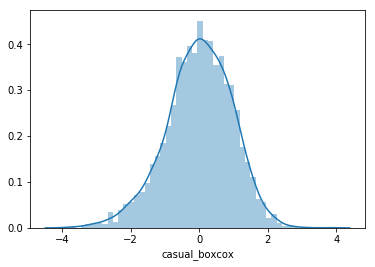

In [37]:
sns.distplot((y_test-y_preds_test),bins=50)
plt.show()

In [38]:
coeffecients = pd.DataFrame(lrm.coef_,X_droped.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
temp,4.543439
hum,-1.486907
windspeed,-0.364458
season_Fall,0.500453
season_Spring,0.493905
weathersit_CLEAR,0.565076
weathersit_MIST,0.593935
workingday_HOLIDAY,0.432591
workingday_WORK,-0.432591
part_day_afternoon,1.009447


__Our model is not complex, it doesn't have overfit problem with small generalization gap.
Casual bike rental is estimated by the factors above.__

## Classification

In [39]:
# Assumption: 50 bikes are always prepared for casual rental.
# When do we need to prepare extra bikes if casual bike rental is over 50?
def overFifty(x) :
    if x > 50 :
        return 1 # OVER
    else : 
        return 0 # NORMAL

df['over_casual'] = df['casual'].apply(lambda x : overFifty(x))

In [40]:
y = df['over_casual']
continuous = ['temp', 'hum', 'windspeed']
categorical = ['season', 'weathersit','workingday', 'part_day']
X = df[continuous+categorical]
X = pd.get_dummies(df[continuous+categorical])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Decision Tree Classifier

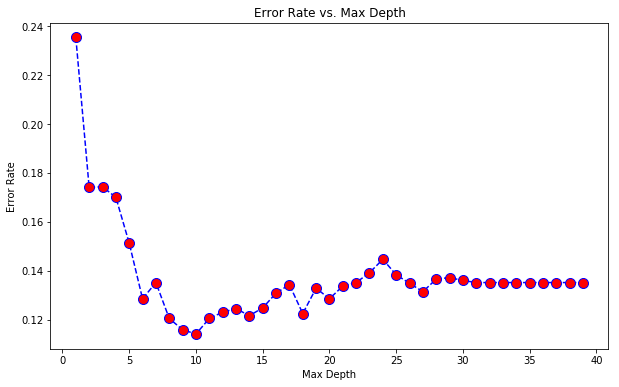

In [42]:
## Play with max_depth

error_rate = []

# Will take some time
for i in range(1,40):
    dtree = DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=i,
    random_state = 1337
    )
    dtree.fit(X_train,y_train)
    pred_i = dtree.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
#     print(i, pred_i != y_test)
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.show()

In [43]:
dtree = DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=10,
    random_state = 1337
)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

In [44]:
predictions = dtree.predict(X_test)
dtree_report = classification_report(y_test,predictions)
dtree_confusion = confusion_matrix(y_test,predictions)

In [45]:
print(dtree_report)
print(dtree_confusion)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2652
           1       0.77      0.73      0.75       824

   micro avg       0.89      0.89      0.89      3476
   macro avg       0.85      0.83      0.84      3476
weighted avg       0.88      0.89      0.88      3476

[[2477  175]
 [ 222  602]]


In [46]:
dtree_sensitivity = dtree_confusion[1][1] / dtree_confusion[1].sum()
print(dtree_sensitivity)
dtree_specificity = dtree_confusion[0][0] / dtree_confusion[0].sum()
print(dtree_specificity)

0.7305825242718447
0.9340120663650076


In [47]:
dtree_cross_val = cross_val_score(dtree, X, y, cv=10)

In [48]:
dtree_feature_imp = pd.DataFrame()
dtree_feature_imp['features'] = X.columns
dtree_feature_imp['importance'] = dtree.feature_importances_

In [49]:
dtree_feature_imp.sort_values(by='importance', ascending = False)

,features,importance
0,temp,0.326031
13,part_day_afternoon,0.212050
16,part_day_night,0.128556
1,hum,0.120269
12,workingday_WORK,0.096994
2,windspeed,0.028870
11,workingday_HOLIDAY,0.024921
15,part_day_morning,0.017661
6,season_Winter,0.011208
4,season_Spring,0.007018


## Support Vector Machine Classifier

In [50]:
svm = SVC(kernel = 'linear', probability=True)
svm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [51]:
predictions = svm.predict(X_test)
svm_report = classification_report(y_test,predictions)
svm_confusion = confusion_matrix(y_test,predictions)

In [52]:
print(svm_report)
print(svm_confusion)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2652
           1       0.78      0.70      0.74       824

   micro avg       0.88      0.88      0.88      3476
   macro avg       0.84      0.82      0.83      3476
weighted avg       0.88      0.88      0.88      3476

[[2488  164]
 [ 248  576]]


In [53]:
svm_sensitivity = svm_confusion[1][1] / svm_confusion[1].sum()
print(svm_sensitivity)
svm_specificity = svm_confusion[0][0] / svm_confusion[0].sum()
print(svm_specificity)

0.6990291262135923
0.9381598793363499


In [54]:
svm_cross_val = cross_val_score(dtree, X,y, cv=10)

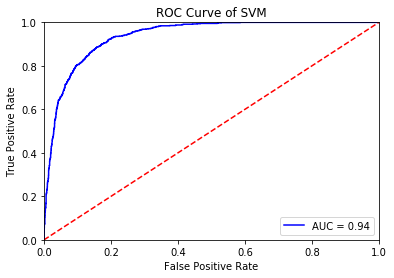

In [55]:
y_scores = svm.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of SVM')
plt.show()

## Gradient Boosting

In [56]:
## Play with max_depth
error_rate = []

# Will take some time
for i in range(1,8):
    print(i)
    params = {'n_estimators': 500,
          'max_depth': i,
          'loss': 'deviance'}
    esmbBoost = ensemble.GradientBoostingClassifier(**params)
    esmbBoost.fit(X_train,y_train)
    pred_i = esmbBoost.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

1
2
3
4
5
6
7


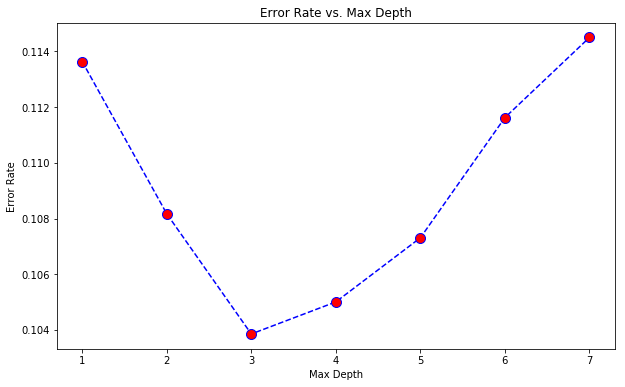

In [57]:
plt.figure(figsize=(10,6))
plt.plot(range(1,8),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.show()

In [58]:
# We'll make 500 iterations, use 3-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}
esmbBoost = ensemble.GradientBoostingClassifier(**params)
esmbBoost.fit(X_train,y_train)
predictions = esmbBoost.predict(X_test)
esmbBoost_report = classification_report(y_test,predictions)
esmbBoost_confusion = confusion_matrix(y_test,predictions)
esmBoost_cross_val = cross_val_score(esmbBoost, X, y, cv=10)

In [59]:
print(esmbBoost_report)
print(esmbBoost_confusion)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2652
           1       0.79      0.77      0.78       824

   micro avg       0.90      0.90      0.90      3476
   macro avg       0.86      0.85      0.86      3476
weighted avg       0.90      0.90      0.90      3476

[[2482  170]
 [ 191  633]]


In [60]:
esmBoost_sensitivity = esmbBoost_confusion[1][1] / esmbBoost_confusion[1].sum()
print(esmBoost_sensitivity)
esmBoost_specificity = esmbBoost_confusion[0][0] / esmbBoost_confusion[0].sum()
print(esmBoost_specificity)

0.7682038834951457
0.9358974358974359


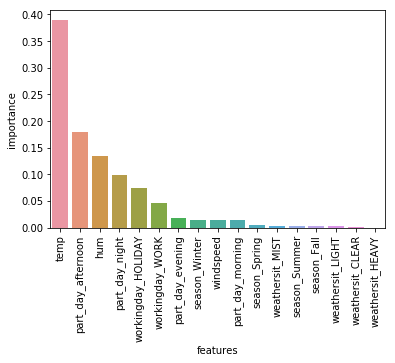

In [61]:
esmbBoost_feature_imp = pd.DataFrame()
esmbBoost_feature_imp['features'] = X.columns
esmbBoost_feature_imp['importance'] = esmbBoost.feature_importances_
esmbBoost_feature_imp = esmbBoost_feature_imp.sort_values(by = 'importance', ascending = False)
sns.barplot(x='features', y = 'importance', data = esmbBoost_feature_imp)
plt.xticks(rotation='vertical')
plt.show()

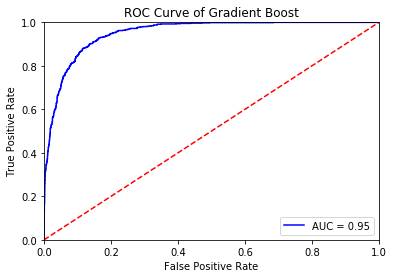

In [62]:
y_scores = esmbBoost.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Gradient Boost')
plt.show()

## Logistic Regression Classification

In [63]:
logmodel = LogisticRegression(solver = 'lbfgs') 
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
logmodel_report = classification_report(y_test,predictions)
logmodel_confusion = confusion_matrix(y_test,predictions)

In [64]:
print(logmodel_report)
print(logmodel_confusion)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2652
           1       0.78      0.68      0.73       824

   micro avg       0.88      0.88      0.88      3476
   macro avg       0.84      0.81      0.83      3476
weighted avg       0.88      0.88      0.88      3476

[[2496  156]
 [ 261  563]]


In [65]:
logmodel_sensitivity = logmodel_confusion[1][1] / logmodel_confusion[1].sum()
print(logmodel_sensitivity)
logmodel_specificity = logmodel_confusion[0][0] / logmodel_confusion[0].sum()
print(logmodel_specificity)

0.683252427184466
0.9411764705882353


In [66]:
logmodel_cross_val = cross_val_score(logmodel,X,y, cv=10)

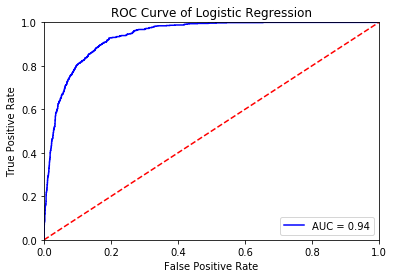

In [67]:
y_scores = logmodel.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

## Ensemble Random Forest Classification

In [68]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
rfc_cross_val = cross_val_score(rfc, X, y, cv=10)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2652
           1       0.77      0.70      0.73       824

   micro avg       0.88      0.88      0.88      3476
   macro avg       0.84      0.82      0.83      3476
weighted avg       0.88      0.88      0.88      3476

[[2478  174]
 [ 245  579]]


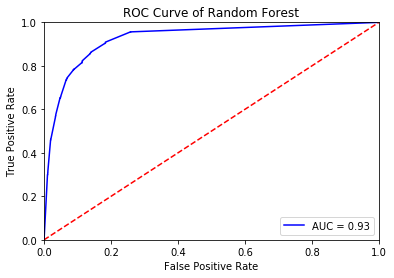

In [70]:
y_scores = rfc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

## KNN Classifier
Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale.


In [71]:
# Play with K
error_rate = []

# Will take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

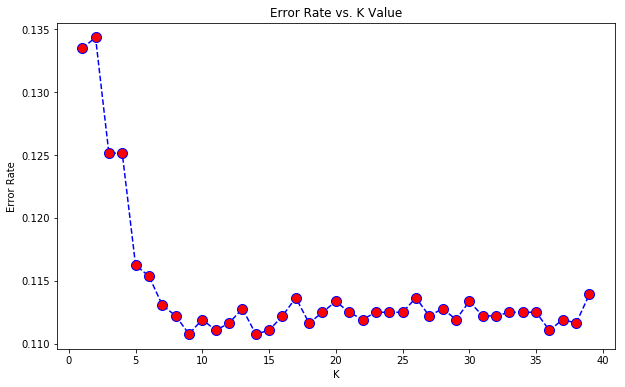

In [72]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

__When k = 9, the error rate is the smallest. I choose this k value for the prediction model.__

In [73]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
knn_cross_val = cross_val_score(knn, X, y, cv=10)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2652
           1       0.78      0.75      0.76       824

   micro avg       0.89      0.89      0.89      3476
   macro avg       0.85      0.84      0.84      3476
weighted avg       0.89      0.89      0.89      3476

[[2475  177]
 [ 208  616]]


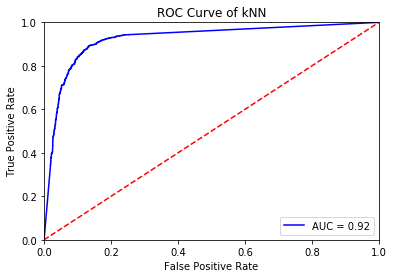

In [74]:
y_scores = knn.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [75]:
df_cross_val = pd.DataFrame()
df_cross_val['Decision tree'] = dtree_cross_val
df_cross_val['Random forest'] = rfc_cross_val
df_cross_val['SVM classifier'] = svm_cross_val
df_cross_val['Gradient Boosting'] = esmBoost_cross_val
df_cross_val['Logistic Regression'] = logmodel_cross_val
df_cross_val['KNN classifier'] = knn_cross_val

In [76]:
df_cross_val.describe()

,Decision tree,Random forest,SVM classifier,Gradient Boosting,Logistic Regression,KNN classifier
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.830833,0.822026,0.830833,0.844467,0.846365,0.824156
std,0.063483,0.064849,0.063483,0.067382,0.075188,0.067813
min,0.721519,0.719793,0.721519,0.742232,0.723245,0.720368
25%,0.787255,0.778625,0.787255,0.795311,0.810127,0.771864
50%,0.866475,0.842591,0.866475,0.871906,0.859240,0.843457
75%,0.879282,0.880446,0.879282,0.897194,0.904647,0.879009
max,0.888377,0.890742,0.888377,0.916571,0.940161,0.897642


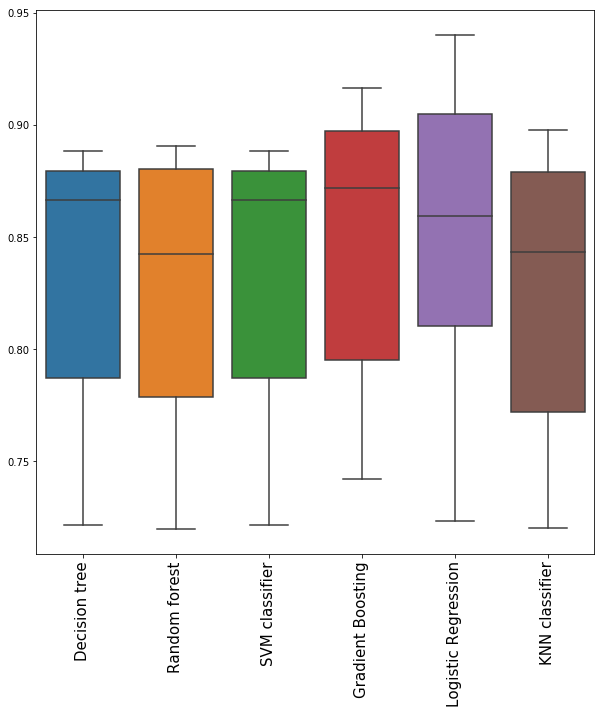

In [77]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_cross_val)
plt.xticks(rotation='vertical',fontsize = 15)
plt.show()